In [6]:
# Imports & Setup
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Prepare Data (CIFAR-10)
# Resize to 224x224 for MobileNet compatibility
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Downloading dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# 3. Model Setup Function
def get_mobilenet():
    model = models.mobilenet_v2(pretrained=True)
    # Adjust classifier for CIFAR-10 (10 classes)
    model.classifier[1] = nn.Linear(model.last_channel, 10)
    model.to(device)
    return model

print("Setup Complete.")

Using device: cuda
Setup Complete.


In [7]:
# Helper Functions

# Measure Size (MB)
def get_model_size(model, path="temp.pth"):
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return size_mb

# Measure Accuracy & Latency
def evaluate_model(model, loader, samples=100):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            if i >= samples: break # Limit for speed
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()
    acc = 100 * correct / total
    # Average time per image in milliseconds
    latency = ((end_time - start_time) / total) * 1000
    return acc, latency

# Pruning Function (Supports Two Heuristics)
def apply_pruning(model, amount, method="l1"):
    # Target all Conv2D and Linear layers
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    if method == "l1":
        # Heuristic 1: L1 Unstructured (Remove smallest weights)
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=amount,
        )
    elif method == "random":
        # Heuristic 2: Random Unstructured (Remove random weights)
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.RandomUnstructured,
            amount=amount,
        )

    # Make pruning permanent
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

print("Helpers Ready.")

Helpers Ready.


In [8]:
# Prepare Baseline Model

print("Preparing Baseline Model (Fine-tuning)...")
baseline_model = get_mobilenet()

# Quick Train Loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)

baseline_model.train()
# Train for just 50 batches to save time (increase for better results)
for i, (inputs, labels) in enumerate(trainloader):
    if i > 50: break
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = baseline_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

# Save the trained weights to disk so we can reload them for every experiment
torch.save(baseline_model.state_dict(), "baseline_weights.pth")

base_acc, base_lat = evaluate_model(baseline_model, testloader)
base_size = get_model_size(baseline_model)
print(f"Baseline -> Acc: {base_acc:.2f}%, Size: {base_size:.2f}MB, Latency: {base_lat:.2f}ms")

Preparing Baseline Model (Fine-tuning)...
Baseline -> Acc: 53.62%, Size: 9.17MB, Latency: 2.33ms


In [10]:
# Running Experiments

sparsity_levels = [0.2, 0.4, 0.6, 0.8]

results = {
    'sparsity': sparsity_levels,
    'oneshot_l1': [],
    'iterative_l1': [],
    'oneshot_random': []
}

# Added 'Time (ms)' to the header
print(f"{'Method':<20} | {'Sparsity':<10} | {'Acc (%)':<10} | {'Size (MB)':<10} | {'Time (ms)':<10}")
print("-" * 75)

# 1. One-Shot L1 Pruning
for s in sparsity_levels:
    model = get_mobilenet()
    model.load_state_dict(torch.load("baseline_weights.pth"))

    apply_pruning(model, amount=s, method="l1")

    # Capture latency here (change '_' to 'lat')
    acc, lat = evaluate_model(model, testloader)
    size = get_model_size(model)

    results['oneshot_l1'].append(acc)
    print(f"{'One-Shot L1':<20} | {s*100:<10.0f} | {acc:<10.2f} | {size:<10.2f} | {lat:<10.2f}")

# 2. Iterative L1 Pruning
model_iter = get_mobilenet()
model_iter.load_state_dict(torch.load("baseline_weights.pth"))
current_sparsity = 0

for s in sparsity_levels:
    amount = (s - current_sparsity) / (1 - current_sparsity)
    apply_pruning(model_iter, amount=amount, method="l1")

    # Capture latency
    acc, lat = evaluate_model(model_iter, testloader)
    size = get_model_size(model_iter)

    results['iterative_l1'].append(acc)
    current_sparsity = s
    print(f"{'Iterative L1':<20} | {s*100:<10.0f} | {acc:<10.2f} | {size:<10.2f} | {lat:<10.2f}")

# 3. One-Shot Random Pruning
for s in sparsity_levels:
    model = get_mobilenet()
    model.load_state_dict(torch.load("baseline_weights.pth"))

    apply_pruning(model, amount=s, method="random")

    # Capture latency
    acc, lat = evaluate_model(model, testloader)
    size = get_model_size(model)

    results['oneshot_random'].append(acc)
    print(f"{'One-Shot Random':<20} | {s*100:<10.0f} | {acc:<10.2f} | {size:<10.2f} | {lat:<10.2f}")

Method               | Sparsity   | Acc (%)    | Size (MB)  | Time (ms) 
---------------------------------------------------------------------------
One-Shot L1          | 20         | 53.11      | 9.17       | 1.89      
One-Shot L1          | 40         | 49.14      | 9.17       | 1.92      
One-Shot L1          | 60         | 10.73      | 9.17       | 1.90      
One-Shot L1          | 80         | 10.33      | 9.17       | 2.00      
Iterative L1         | 20         | 53.11      | 9.17       | 1.91      
Iterative L1         | 40         | 53.89      | 9.17       | 1.86      
Iterative L1         | 60         | 53.14      | 9.17       | 1.86      
Iterative L1         | 80         | 19.50      | 9.17       | 1.83      
One-Shot Random      | 20         | 10.33      | 9.17       | 1.82      
One-Shot Random      | 40         | 10.06      | 9.17       | 1.85      
One-Shot Random      | 60         | 10.00      | 9.17       | 1.82      
One-Shot Random      | 80         | 9.94       |

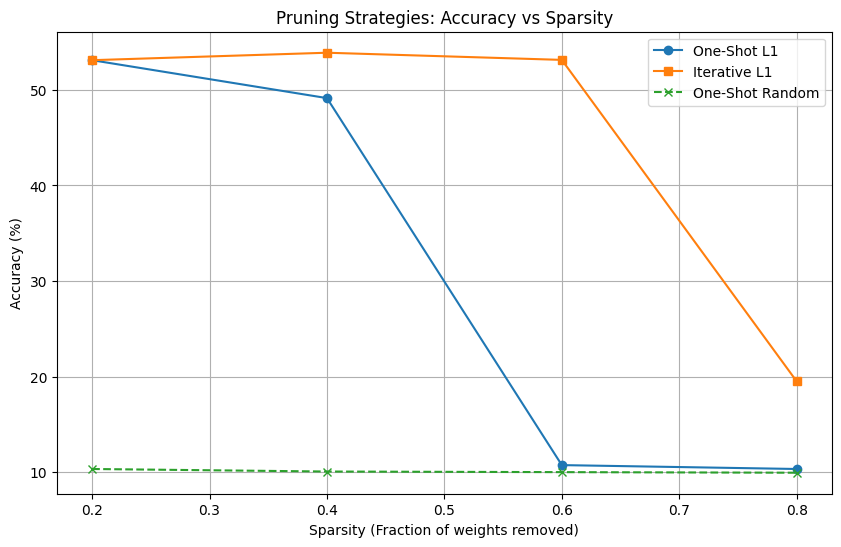

In [12]:
# Visualization
plt.figure(figsize=(10, 6))

# Plot all three lines
plt.plot(results['sparsity'], results['oneshot_l1'], marker='o', label='One-Shot L1')
plt.plot(results['sparsity'], results['iterative_l1'], marker='s', label='Iterative L1')
plt.plot(results['sparsity'], results['oneshot_random'], marker='x', linestyle='--', label='One-Shot Random')

plt.title("Pruning Strategies: Accuracy vs Sparsity")
plt.xlabel("Sparsity (Fraction of weights removed)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

